In [3]:
import os
os.chdir("..")

## Projection

In [2]:
import numpy as np

from classifier_3D.utils.ply_file import read_ply
from classifier_3D.utils.path import get_data_path

file_path = get_data_path("MiniLille1.ply", True)
n_points = 100_000

cloud, _ = read_ply(file_path)
points = np.vstack((cloud["x"], cloud["y"], cloud["z"])).T.astype(np.float32)

chosen_points = np.random.choice(np.arange(points.shape[0]), size=n_points, replace=False)
points = points[chosen_points]

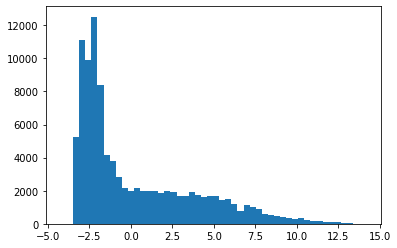

0.26886183
-0.7269610404968261
[ 0.2053413 -1.0271943 -0.726961 ]


In [3]:
import matplotlib.pyplot as plt

bin_count, bin_boxes, _ = plt.hist(points[:, -1], bins=50)
plt.show()
print(points[:, -1].mean())

z_center = (bin_boxes[np.argmax(bin_count) + 1] + bin_boxes[np.argmax(bin_count) + 2]) / 2 + 1.1
print(z_center)

center_of_projection = points.mean(axis=0)
center_of_projection[-1] = z_center
print(center_of_projection)

centered_points = points - center_of_projection

In [5]:
theta = 3 * np.pi / 4

rot = np.array([[np.cos(theta), - np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])

rot_points = centered_points @ rot.T

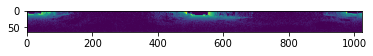

In [6]:
from range_net.laserscan import LaserScan

laser_scan = LaserScan(project=True)

laser_scan.set_points(rot_points)

_ = plt.imshow(laser_scan.proj_range)

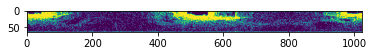

In [7]:
_ = plt.imshow(laser_scan.proj_mask)

In [ ]:
### Put the projection in the direction of the road :)

## Save bin and label

In [8]:
import numpy as np

from classifier_3D.utils.ply_file import read_ply
from classifier_3D.utils.path import get_data_path

file_path = get_data_path("MiniLille1.ply", is_train_data=True)
n_points = 100_000

cloud, _ = read_ply(file_path)
points = np.vstack((cloud["x"], cloud["y"], cloud["z"])).T.astype(np.float32)
labels = cloud["class"]

chosen_points = np.random.choice(np.arange(points.shape[0]), size=n_points, replace=False)
points = points[chosen_points]
labels = labels[chosen_points]

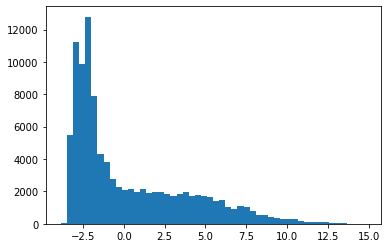

0.27318385
-0.7027954101562499
[ 0.21396431 -1.0107554  -0.7027954 ]


In [9]:
import matplotlib.pyplot as plt

bin_count, bin_boxes, _ = plt.hist(points[:, -1], bins=50)
plt.show()
print(points[:, -1].mean())

z_center = (bin_boxes[np.argmax(bin_count) + 1] + bin_boxes[np.argmax(bin_count) + 2]) / 2 + 1.1
print(z_center)

center_of_projection = points.mean(axis=0)
center_of_projection[-1] = z_center
print(center_of_projection)

centered_points = points - center_of_projection

In [10]:
bin_points = np.hstack((centered_points, np.zeros((centered_points.shape[0], 1))))

In [11]:
bin_points.astype(np.float32).tofile("MiniLille1.bin")
labels.tofile("MiniLille1.label")

## Analyse Kitti dataset

In [2]:
import numpy as np

points_kitti = np.fromfile("data/000000.bin", dtype=np.float32).reshape((-1, 4))
print(points_kitti.shape)
points_kitti.mean(axis=0)

FileNotFoundError: [Errno 2] No such file or directory: 'data/000000.bin'

In [13]:
print(np.fromfile("MiniLille1.bin", dtype=np.float32).reshape((-1, 4)).shape)
np.fromfile("MiniLille1.bin", dtype=np.float32).reshape((-1, 4)).mean(axis=0)

(100000, 4)


array([-6.8732976e-07,  2.3386192e-06,  9.7598195e-01,  0.0000000e+00],
      dtype=float32)

In [14]:
print(bin_points.shape)
bin_points.mean(axis=0)

(100000, 4)


array([-2.70276964e-07,  2.79134393e-06,  9.75979248e-01,  0.00000000e+00])

In [15]:
print(points.mean(axis=0))
print(center_of_projection)

[ 0.21396431 -1.0107554   0.27318263]
[ 0.21396431 -1.0107554  -0.7027954 ]
